# Logistic Regression — Pima Indians Diabetes Dataset

This notebook demonstrates **binary logistic regression** implemented entirely from scratch using the custom `LogisticRegression` class from the `rice_ml` package.

We apply the model to the **Pima Indians Diabetes dataset**, a classic benchmark for binary classification in medical diagnostics.


## Objectives

In this notebook, we will:

- Load and inspect a real-world medical dataset  
- Perform exploratory data analysis (EDA)  
- Standardize features for numerical stability  
- Train a logistic regression classifier using gradient descent  
- Evaluate performance using accuracy, confusion matrix, and ROC–AUC  
- Interpret results from both a statistical and machine learning perspective  


## Imports

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from rice_ml.supervised_learning.logistic_regression import LogisticRegression
from rice_ml.processing.preprocessing import standardize, train_test_split
from rice_ml.processing.post_processing import accuracy_score, confusion_matrix

## Load Dataset

We will load the Pima Indians Diabetes dataset directly from a public URL.

## Dataset Description

The **Pima Indians Diabetes dataset** contains medical diagnostic measurements used to predict whether a patient has diabetes.

### Features

- `pregnancies`: number of pregnancies  
- `glucose`: plasma glucose concentration  
- `blood_pressure`: diastolic blood pressure (mm Hg)  
- `skin_thickness`: triceps skin fold thickness (mm)  
- `insulin`: 2-hour serum insulin (mu U/ml)  
- `bmi`: body mass index  
- `diabetes_pedigree`: diabetes pedigree function  
- `age`: age in years  

### Target

- `label`: binary outcome  
  - `1` → diabetes  
  - `0` → no diabetes  

### Data Notes

- All features are numerical   
- No explicit NaN values are present  
- Feature scales differ substantially, motivating standardization
- Several variables contain **zero values that represent missing or implausible measurements**. In this notebook, we retain these values as-is to keep the modeling pipeline simple and focused on demonstrating logistic regression from scratch. However, in a production or clinical setting, these values would typically be handled via imputation or domain-specific filtering. This limitation should be kept in mind when interpreting model
performance.


In [17]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
cols = [
    "pregnancies", "glucose", "blood_pressure", "skin_thickness",
    "insulin", "bmi", "diabetes_pedigree", "age", "label"
]

df = pd.read_csv(url, header=None, names=cols)
df.head()

,pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Exploratory Data Analysis (EDA)

Before modeling, we examine feature distributions and scale differences to understand the structure of the data.

### Feature Distributions

Histograms reveal skewness, outliers, and non-Gaussian behavior in several features such as insulin and glucose.

### Feature Scale Comparison

Boxplots highlight large differences in scale across features.
Some variables span orders of magnitude larger than others, which can destabilize gradient-based optimization.


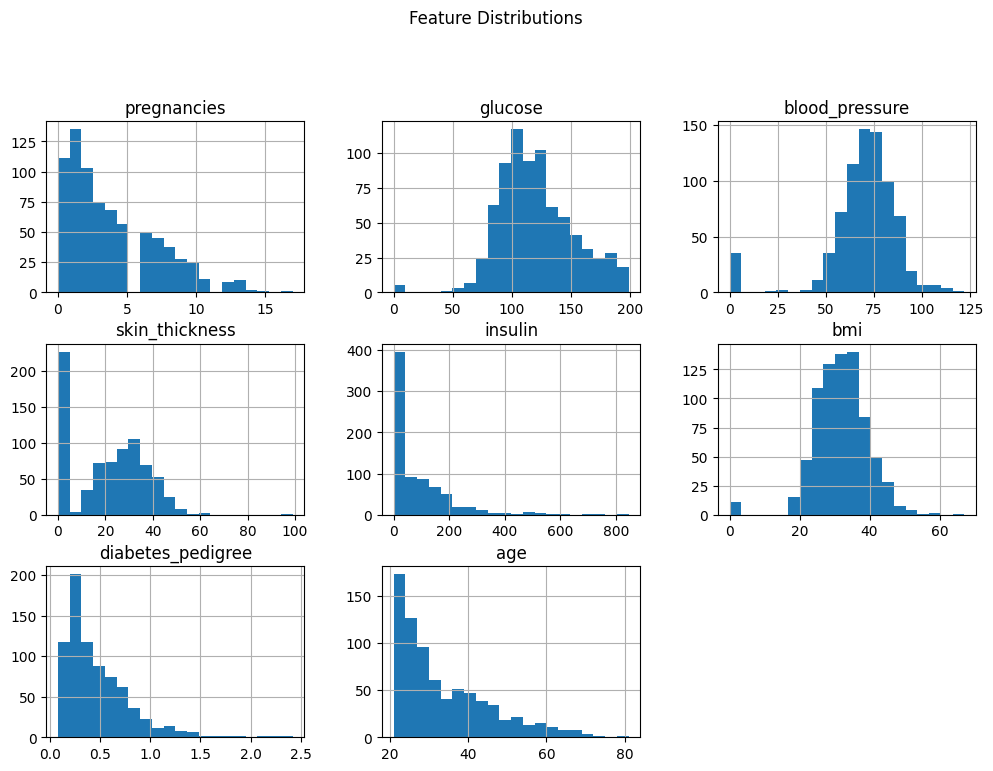

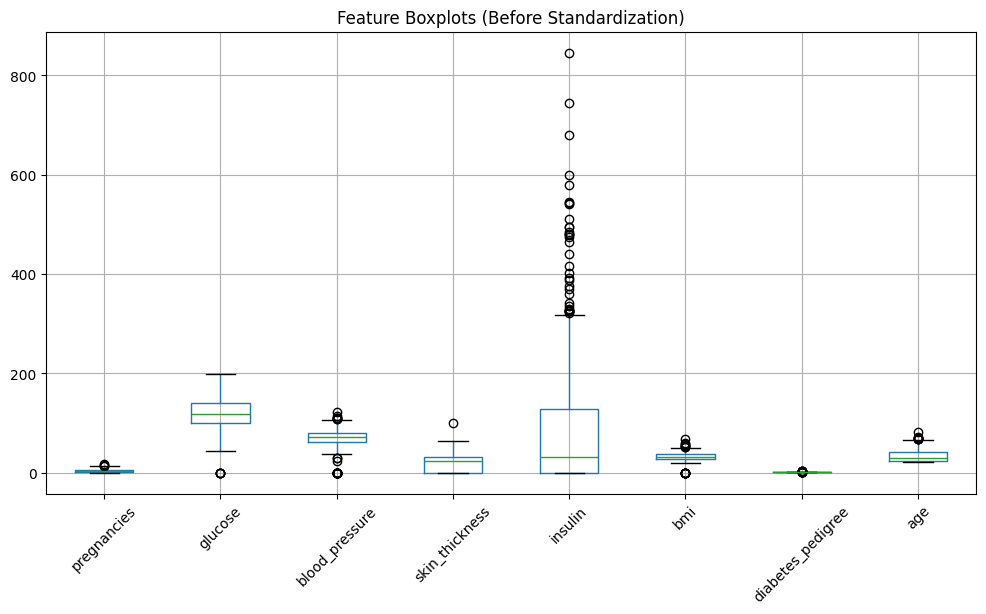

In [18]:
# Feature Distributions
df.drop(columns=["label"]).hist(figsize=(12, 8), bins=20)
plt.suptitle("Feature Distributions", y=1.02)
plt.show()

# Feature Scale Comparison
plt.figure(figsize=(12, 6))
df.drop(columns=["label"]).boxplot(rot=45)
plt.title("Feature Boxplots (Before Standardization)")
plt.show()

## EDA Interpretation

- Features vary widely in scale (e.g., insulin vs diabetes pedigree)  
- Several variables are right-skewed and contain outliers  
- Logistic regression relies on gradient descent, which is sensitive to feature scale  

These observations motivate **feature standardization** prior to model training.


## Preprocessing

We separate predictors and target, then standardize the features.

Let the feature matrix be:

- Feature matrix: $X \in \mathbb{R}^{n \times d}$  
- Target vector: $y \in \{0,1\}^n$

Feature standardization is defined as:

$$
X_{\text{std}} = \frac{X - \mu}{\sigma}
$$

This ensures:

- Comparable feature scales  
- Faster and more stable gradient descent  
- Improved numerical conditioning  


In [19]:
X = df.drop(columns=["label"]).values
y = df["label"].values.astype(float)

X_std = standardize(X)

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((615, 8), (153, 8))

## Logistic Regression — Model Intuition

Logistic regression models the probability of the positive class as:

$$
P(y = 1 \mid x) = \sigma(w^\top x + b)
$$

where the sigmoid function is:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$


### Loss Function (Log-Loss)

We minimize the **binary cross-entropy loss**:

$$
\mathcal{L}(w) =
-\frac{1}{n} \sum_{i=1}^n
\left[
y_i \log(\hat{p}_i) + (1 - y_i)\log(1 - \hat{p}_i)
\right]
$$

This loss is:

- Convex  
- Differentiable  
- Well-suited for probabilistic classification  


## Model Training
We train logistic regression using gradient descent.

$$
\hat{y} = \sigma(Xw) = \frac{1}{1 + e^{-Xw}}
$$

We minimize the log-loss:

$$
\mathcal{L} = -\frac{1}{n} \sum_i \big( y_i\log(\hat{y}_i) + (1 - y_i)\log(1-\hat{y}_i) \big)
$$

In [20]:
model = LogisticRegression(
    learning_rate=0.1,
    max_iter=5000,
    C=1.0
)

model.fit(X_train, y_train)

print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)


Intercept: -0.7449873920888598
Coefficients: [0.07763563 0.16801187 0.00996418 0.01877883 0.02928685 0.10656582
 0.05652058 0.08235564]


### Model Coefficient Interpretation

Each coefficient represents the change in log-odds of diabetes
associated with a one standard deviation increase in the corresponding
feature (holding all others constant).

Positive coefficients increase diabetes risk, while negative
coefficients decrease it. Because features are standardized, coefficient
magnitudes are directly comparable across variables.


## Evaluation Metrics

### Accuracy

Accuracy is defined as:

$$
\text{Accuracy} =
\frac{1}{n} \sum_{i=1}^n
\mathbf{1}\bigl[\hat{y}_i = y_i\bigr]
$$

where:

- $y_i$ is the true label  
- $\hat{y}_i$ is the predicted label  
- $\mathbf{1}[\cdot]$ is the indicator function  

### Confusion Matrix

The confusion matrix provides class-specific insight into:

- False positives (Type I error)  
- False negatives (Type II error)  

This is particularly important in medical prediction tasks, where false negatives may be costly.



In [ ]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", acc)
print("Confusion Matrix:\n", cm)

Accuracy: 0.5490196078431373
Confusion Matrix:
 [[83  0]
 [69  1]]
AUC: 0.7673838209982787


### Why Is Accuracy Relatively Low?

The Pima Indians Diabetes dataset is noisy, partially incomplete, and
not linearly separable. Logistic regression assumes a linear decision
boundary, which limits its expressive power on this task.

Additionally, several features contain zero values that represent
missing or implausible measurements, which negatively impacts linear
models. Finally, accuracy depends on a fixed classification threshold,
while ROC–AUC reveals that the model still ranks patients reasonably
well across thresholds.

For these reasons, logistic regression serves as an interpretable
baseline rather than a high-accuracy classifier on this dataset.


## Probability Histogram

The distribution of predicted probabilities shows how confidently the
model separates diabetic and non-diabetic cases. Overlapping regions
indicate ambiguous cases where medical features provide weaker signals.


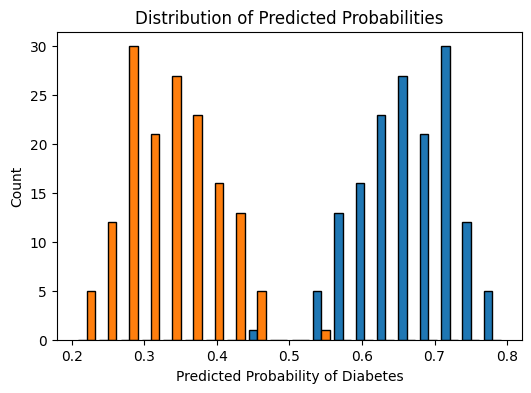

In [22]:
probs = model.predict_proba(X_test)

plt.figure(figsize=(6,4))
plt.hist(probs, bins=20, edgecolor="k")
plt.xlabel("Predicted Probability of Diabetes")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities")
plt.show()


## ROC Curve and AUC

The **Receiver Operating Characteristic (ROC)** curve evaluates classifier performance across all classification thresholds.

- True Positive Rate (TPR):

$$
\text{TPR} = \frac{TP}{TP + FN}
$$

- False Positive Rate (FPR):

$$
\text{FPR} = \frac{FP}{FP + TN}
$$

The **Area Under the Curve (AUC)** summarizes overall discriminative performance.


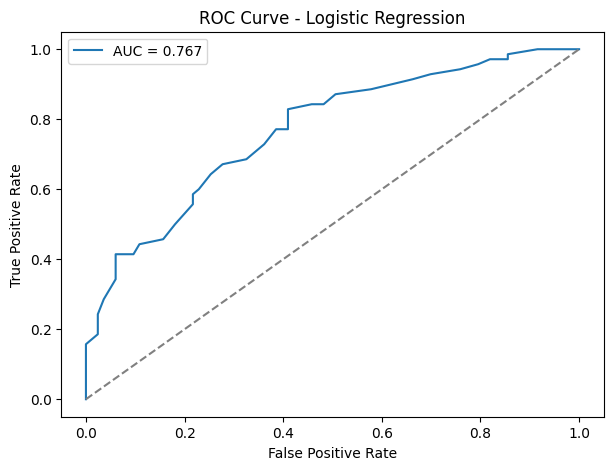

In [23]:
fpr, tpr, auc = model.roc_curve(X_test, y_test)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

### Interpretation of ROC and AUC

The ROC curve evaluates classifier performance across all possible
decision thresholds. While accuracy depends on a fixed threshold
(default 0.5), AUC measures the model’s ability to rank positive cases
higher than negative ones independent of threshold choice.

In medical applications, thresholds may be adjusted to prioritize
sensitivity (reducing false negatives) or specificity depending on
clinical risk. Logistic regression naturally supports this flexibility
through probabilistic outputs.


## Conclusion

In this notebook, we implemented logistic regression from scratch and applied it to the Pima Indians Diabetes dataset.

Key takeaways:

- Logistic regression provides an interpretable, probabilistic baseline for binary classification.
- Feature standardization is essential for stable and efficient gradient descent.
- Model performance is limited by the dataset’s noise, implicit missing values, and non-linear structure.
- ROC–AUC offers a more informative evaluation metric than accuracy for this task.

Although logistic regression does not achieve high accuracy on this dataset, it serves as a strong and explainable baseline against which more complex models can be compared.
